In [56]:
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import networkx as nx
import numpy as np
from contextily import add_basemap
from libpysal import weights
import time
import shapely

In [72]:
roads = gpd.read_file('road_vertices_3857.zip')[['LengthM', 'geometry', 'FULLNAME', 'MTFCC', 'StartX', 'StartY']]
roads = roads[(roads['MTFCC'] == 'S1100') | (roads['MTFCC'] == 'S1200')]

In [73]:
roads

,LengthM,geometry,FULLNAME,MTFCC,StartX,StartY
3,18.516209,"LINESTRING (-9167850.519 3465923.731, -9167834...",NW 34th St Exd,S1200,-9.167851e+06,3.465924e+06
4,29.172709,"LINESTRING (-9167834.489 3465937.829, -9167809...",NW 34th St Exd,S1200,-9.167834e+06,3.465938e+06
5,41.052833,"LINESTRING (-9167809.887 3465960.77, -9167777....",NW 34th St Exd,S1200,-9.167810e+06,3.465961e+06
6,29.633587,"LINESTRING (-9167777.159 3465994.99, -9167756....",NW 34th St Exd,S1200,-9.167777e+06,3.465995e+06
7,18.161785,"LINESTRING (-9167756.899 3466022.545, -9167744...",NW 34th St Exd,S1200,-9.167757e+06,3.466023e+06
...,...,...,...,...,...,...
179395,73.492484,"LINESTRING (-9185931.815 3459169.604, -9186016...",Co Rd 241,S1200,-9.185932e+06,3.459170e+06
179396,48.704555,"LINESTRING (-9186016.306 3459170.757, -9186072...",Co Rd 241,S1200,-9.186016e+06,3.459171e+06
179397,80.269238,"LINESTRING (-9186072.3 3459171.525, -9186164.5...",Co Rd 241,S1200,-9.186072e+06,3.459172e+06
179398,8.133560,"LINESTRING (-9186164.584 3459172.678, -9186173...",Co Rd 241,S1200,-9.186165e+06,3.459173e+06


In [41]:
# https://networkx.org/documentation/stable/auto_examples/geospatial/plot_lines.html
G = momepy.gdf_to_nx(roads, approach="primal", length="LengthM")

nx.set_node_attributes(G, np.inf, "dist")
nx.set_node_attributes(G, None, "pred")

In [50]:
def bellmanford(Graph, source=963):
    # Index of Gainesville Fire Station
    list(Graph.nodes(data=True))[source][1]['dist'] = 0
    for i in range(len(list(G.nodes))):
      for from_vertex in Graph.nodes:
          neighbors = Graph.__getitem__(from_vertex)
          for to_vertex in neighbors:
              du = Graph.nodes[from_vertex]['dist']
              wt = neighbors[to_vertex][0]['LengthM']
              dv = Graph.nodes[to_vertex]['dist']
              if du + wt < dv:
                  Graph.nodes[to_vertex]['dist'] = du + wt
                  Graph.nodes[to_vertex]['pred'] = from_vertex
    return Graph
    '''
    repeat V - 1 times
    for each edge(from u, to v) with weight w in edges do:
        if dist[u] + w < dist[v] then
            dist[v] = dist[u] + w
            pred[v] = u
    '''

In [88]:
# Example: lon = -82.3111426 lat = 29.6520652
print("Welcome to BlazeNav! We will help you determine the closest path from the Gainesville Fire Station to a fire you've just located.")
print("-------------------------------------------------------------")
print("Please enter the coordinates of your fire in decimal degrees.")
fire_lat = input("Enter latitude of fire: ")
fire_lon = input("Enter longtiude of fire: ")
print("-------------------------------------------------------------")

# Find the closest street to the input coordinates and use that as the destination
try:
  # References https://stackoverflow.com/questions/70626218/how-to-find-the-nearest-linestring-to-a-point
  fire_point = gpd.GeoDataFrame(geometry=[shapely.wkt.loads(f"POINT ({fire_lon} {fire_lat})")]).set_crs('EPSG:4326').to_crs('EPSG:3857')
  distance = gpd.sjoin_nearest(fire_point, roads).merge(roads, left_on='index_right', right_index=True)
  distance['distance'] = distance.apply(lambda row: row['geometry_x'].distance(row['geometry_y']), axis=1)
  closest_node_X = distance.iloc[0]['StartX_y']
  closest_node_Y = distance.iloc[0]['StartY_y']
  print("We have identified the location. BlazeNav is now searching for the fastest route from the Gainesville Fire Station #1 to the road nearest to the fire you inputted.")
except:
  print("Coordinates not found in or near Alachua County. Please enter new coordinates.")
  fire_lat = input()
  fire_lon = input()

Welcome to BlazeNav! We will help you determine the closest path from the Gainesville Fire Station to a fire you've just located.
-------------------------------------------------------------
Please enter the coordinates of your fire in decimal degrees.
Enter latitude of fire: 29.6520652
Enter longtiude of fire: -82.3111426
-------------------------------------------------------------
We have identified the location. BlazeNav is now searching for the fastest route from the Gainesville Fire Station #1 to the road nearest to the fire you inputted.


In [51]:
# https://www.geeksforgeeks.org/how-to-check-the-execution-time-of-python-script/
start = time.time()
result = bellmanford(G)
end = time.time()

print("Time to run:", (end-start) * 10**3, "ms")

Time to run: 267711.64774894714 ms


In [ ]:
result.nodes(data=True)

In [91]:
# Find the node of the inputted fire's closest node
for id, node in enumerate(list(G.nodes)):
  if (node[0] <= closest_node_X + 1) & (node[0] >= closest_node_X - 1):
    break

list(result.nodes(data=True))[id]

((-9162836.909668718, 3458895.7367716236),
 {'x': -9162836.909668718,
  'y': 3458895.7367716236,
  'dist': 2158.342724713721,
  'pred': (-9162846.59446722, 3458895.6086774175)})

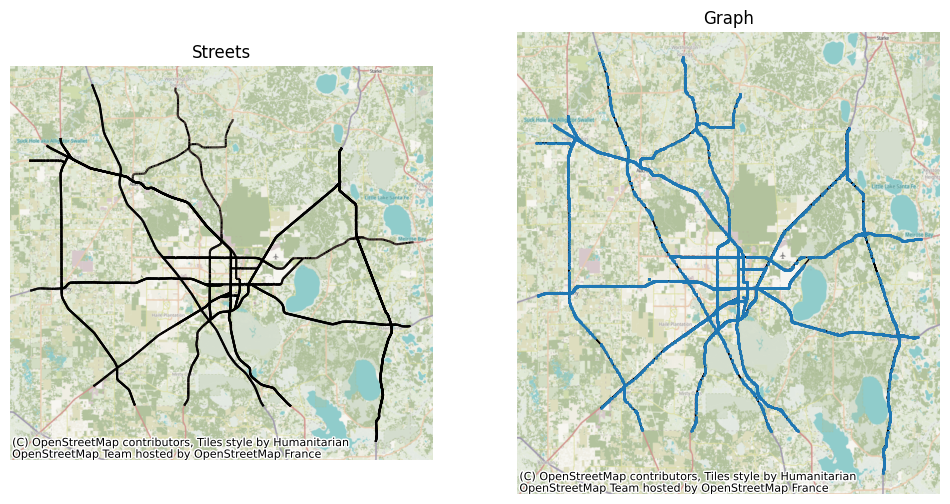

In [54]:
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
roads.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Graph")[i])
    facet.axis("off")
    add_basemap(facet)
nx.draw(
    result, {n: [n[0], n[1]] for n in list(result.nodes)}, ax=ax[1], node_size=1
)

# Notes

In [48]:
# Find the node of the Gainesville Fire Station (-9164362.20975, 3458275.77721)
for id, node in enumerate(list(G.nodes)):
  if (node[0] <= -9164362) & (node[0] >= -9164362.21):
    print(node, id)
    break

(-9164362.209753478, 3458275.7772084177) 963


In [80]:
# Find the node of the inputted fire's closest node
for id, node in enumerate(list(G.nodes)):
  if (node[0] <= closest_node_X + 1) & (node[0] >= closest_node_X - 1):
    print(node, id)
    break

(-9162836.909668718, 3458895.7367716236) 1095


In [ ]:
fire_lat = input("Enter latitude of fire: ")
fire_lon = input("Enter longtiude of fire: ")

# Find the closest street to the input coordinates and use that as the source
try:
  fire_lat
except:
  print("Coordinates not found in or near Alachua County. Please enter new coordinates.")
  fire_lat = input()
  fire_lon = input()

Enter latitude of fire: 1
Enter longtiude of fire: 2


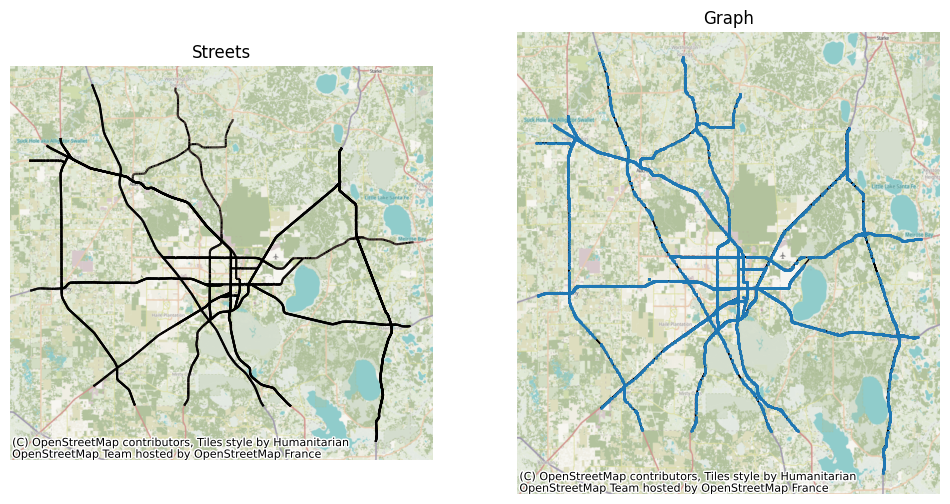

In [46]:
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
roads.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Graph")[i])
    facet.axis("off")
    try:  # For issues with downloading/parsing in CI
        add_basemap(facet)
    except:
        pass
nx.draw(
    result, {n: [n[0], n[1]] for n in list(result.nodes)}, ax=ax[1], node_size=1
)